# Notebook to get the NLC data... 

In [3]:
# first, let's login to Data Lab server: 
from dl import authClient as ac, queryClient as qc, storeClient as sc
from getpass import getpass
# Get token for an authenticated user if you wish to use virtual storage or myDB
token = ac.login(input("Enter user name: "),getpass("Enter password: "))

Enter user name: suberlak
Enter password: ········


In [4]:
# Import packages including some Data Lab (dl) specific ones.
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from astropy.utils.data import download_file  #import file from URL
from scipy.stats import binned_statistic_2d
from astropy.table import Table
from dl import authClient as ac, queryClient as qc
from dl import helpers
%matplotlib inline
# from cStringIO import StringIO  # C script to handle string format, Python 2
from io import StringIO   # Python 3 version
print('Done importing')

Done importing


## Test queries from GettingStarted...

In [ ]:
# Try the example query from GettingStartedWithDataLab : 

query="SELECT * FROM tbl_stat WHERE schema='smash_dr1' and tbl_name='object'" 

In [ ]:
%%time
try:
    info = qc.query(token,sql=query) # by default the result is a CSV formatted string
except Exception as e:
    print(e.message)

In [ ]:
print(info)

In [ ]:
%%time
query="SELECT * FROM smash_dr1.object LIMIT 10"
try:
    result = qc.query(token,sql=query) # by default the result is a CSV formatted string
except Exception as e:
    print(e.message)

In [ ]:
print(type(result))
print(result[0:99])
df = helpers.convert(result,'pandas')
print(df)

## Query  the NSC

In [ ]:
# what tables do we have in NSC Data Release 1?  
print(qc.schema('nsc_dr1',format='json',profile='default'))
print(qc.schema('nsc_dr1.object',format='json',profile='default'))



Execute a simple query to get basic astrometry and photometry for NSC sources from the SDSS Stripe 82 region.
SDSS Stripe 82 region: about 2.5 deg wide equatorial strip from RA=20h to RA=4h.
For the entire Stripe 82 region, the query below should have "dec > -1.3 and dec < 1.3" instead of "dec > -0.3 and dec < 0.3"

In [ ]:
decTitles = ['positive', 'negative']
decLimsList = [[-1.3, 0], [0, 1.3]]

for decTitle, decLims in zip(decTitles, decLimsList) : 

    decMin, decMax = decLims
    # Write query statement (adql) to retrieve data from ls_dr5.tractor_primary table
    query = """
            SELECT ra, dec, pmra, pmraerr, pmdec, pmdecerr, mjd, deltamjd, 
                   gmag, grms, gerr, rmag, rrms, rerr, imag, irms, ierr,
                   class_star, fwhm, ebv, nphot 
            FROM nsc_dr1.object 
            WHERE (((ra > 315 or ra<45)) and dec > """ +str(decMin)+\
            " and dec < " +str(decMax)+\
            """ and rmag > 13 and rmag < 23.0 and rerr < 0.3)
            LIMIT 8000000"""
    response = qc.query(token, sql=query, fmt='csv')

    print('Done with query')

    # convert to Pandas 
    df = helpers.convert(response,'pandas')

    # Check the length to ensure we have all rows ...
    print(len(df))

    # Save as csv ...
    fname = 'NSC_stripe82_Dec_'+decTitle+'.csv'
    print('Saving as ', )
    df.to_csv(fname,index=False)         # 1,793,566

Done with query


/data0/sw/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2802: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Returning Pandas dataframe
3716545
Saving as 


In [41]:
# Check the length to ensure we have all rows ...
len(df)
# should be 3,692,781 + 3,716,545 = 7,409,326

5037663

In [ ]:
# It's only 5,037,663 ... 


In [ ]:
# Save the full one as csv ...
# if in the query above had   dec > -1.3 and dec < 1.3  ... 
#df.to_csv('NSC_stripe82_DecNarrow.csv',index=False)         # 1,793,566

In [37]:
# Save the narrow one as csv ...
# if in the query above had   dec > -0.3 and dec < 0.3  ... 
#df.to_csv('NSC_stripe82_DecNarrow.csv',index=False)         # 1,793,566

## Make the quality plots :

In [42]:
result = df

ra = result['ra']
dec = result['dec'] 
rmag = result['rmag'] 
rmagerr = result['rerr'] 
rmagrms = result['rrms'] 
rr = rmagrms/rmagerr 
pmra = result['pmra'] 
pmdec = result['pmdec'] 
pmraerr = result['pmraerr'] 
pmdecerr = result['pmdecerr'] 
SG = result['class_star']
nphot = result['nphot']
deltamjd = result['deltamjd']

In [43]:
ra = result['ra']
dec = result['dec'] 
raW = np.where(ra>180, ra-360, ra)
snr = 1.0/rmagerr
SNRcutBright = 20.0
SNRcutFaint = 10.0
raS = ra[(snr<SNRcutBright)&(snr>SNRcutFaint)]
raWS = raW[(snr<SNRcutBright)&(snr>SNRcutFaint)]
decS = dec[(snr<SNRcutBright)&(snr>SNRcutFaint)]
np.size(raS)


1169412

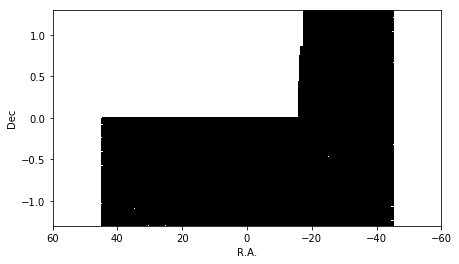

In [44]:
# plot data
fig = plt.figure(figsize=(12, 12))
ax = fig.add_axes([0.5, 0.7, 0.45, 0.25])
ax.plot(raWS, decS, color='k', linestyle='none', marker=',')
ax.set_xlim(60, -60.0)
ax.set_ylim(-1.3, 1.3)
ax.set_xlabel('R.A.')
ax.set_ylabel('Dec')
plt.show()

It looks almost like it did not retrieve all dec asked for .... 

Perhaps better to split into two parts:  north and south ! 